# Classification Metrics: Introducing the Confusion Matrix

## Objectives

- Calculate and interpret a confusion matrix
- Calculate and interpret classification metrics such as accuracy, recall, and precision
- Choose classification metrics appropriate to a business problem

# Motivation

There are many ways to evaluate a classification model, and your choice of evaluation metric can have a major impact on how well your model serves its intended goals. This lecture will review common classification metrics you might consider using, and considerations for how to make your choice.

Let's start off with a page from [Google's Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative) and talk about a classic classification problem:

## The Boy Who Cried 'Wolf'

![adorable wolf image from instagram user fablefire: https://www.instagram.com/p/CCGgVLGFneE/](images/awoo.png)

In the old fable about the boy who cried 'wolf' there are two possible outcomes: 

- **No Wolf** - negative outcome, or 0
- **Wolf** - positive outcome, or 1

(I know, having a wolf arrive is not "positive" - but it is what we're trying to predict)

If you think of this as a model, where the shepherd is predicting whether or not a wolf will threaten the flock of sheep:

![outcome description for wolf scenarios as a confusion matrix](images/wolf_confusion_matrix.png)

So what does that look like with data?

In [1]:
# All of the imports

import pandas as pd
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml, load_breast_cancer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
# Getting the data from sklearn
dfX, dfy = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
# Cleaning a bit to get to a full dataframe of the data
df = dfX.copy()
df = df.drop(columns=['boat', 'body', 'home.dest'])
df['survived'] = dfy

df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,0


In [3]:
df['survived'].value_counts()

0    809
1    500
Name: survived, dtype: int64

### Model-less Baseline

First of all, I want to see how well the model will do if it predicts the majority class. In other words, if the model only predicts that no one survives, what percentage of the time would it be right? 

How do we do this? Find the number of passengers who didn't survive, divide by the total number of passengers - which `value_counts` will do for us if we set `normalize=True`.

In [4]:
df['survived'].value_counts(normalize=True)

0    0.618029
1    0.381971
Name: survived, dtype: float64

To visualize:

In [5]:
y_actual = df['survived']

In [6]:
y_pred_baseline = ['0'] * len(df)

In [7]:
accuracy_score(y_actual, y_pred_baseline)

0.6180290297937356

In [8]:
# A confusion matrix
confusion_matrix(y_actual, y_pred_baseline)

array([[809,   0],
       [500,   0]], dtype=int64)

Or, prettier: 

<img alt="table view with colors to show results of modelless baseline" src="images/full_titanic_modelless_baseline_cm.png" height=200 width=200>

#### Evaluate:

What is this showing us? Why two zeros on the right side?

- 


## Confusion Matrix &rarr; Classification Metrics

That block above, where we hashed out true negatives / true positives / false negatives / false positives, is called a **Confusion Matrix** - a summary of how well a classification model was able to predict each class. Across one axis you have the _predicted_ labels, and across the other axis you have the _actual_ labels, and thus you're able to clearly see the breakdown of where a model is making mistakes - and, more importantly, what kinds of mistakes your model is making.

So - how does a confusion matrix translate into classification metrics?

### Confusion Matrix Interpretation


<img alt="confusion matrix interpretation with metrics" src="images/confusion_matrix_interpretation.png" height=600 width=600>

Note that I've highlighted the most often used metrics in blue above. 

In other words, those metrics are:

- Accuracy: All True Predictions / All Predictions

- Precision score: TP / All Predicted Positives

- Recall or Sensitivity: TP / All Actual Positives 

There's one more score that's often referenced which balances precision and recall - it's called an [**F1 Score**](https://en.wikipedia.org/wiki/F1_score).

$$ \text{F1 Score} = 2 * \frac{ precision * recall}{precision + recall} $$



**Let's Discuss**: Why might we care more about precision than recall, or vice versa? In other words, which one of these would you think is the **primary metric** for the business problem of predicting whether or not someone survived the Titanic?

- 



Let's calculate the above highlighted classification metrics and consider which would be most useful for this scenario.

First, though, we'll create a real model for the Titanic, generally using the strategy outlined by SKLearn [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html) (although, we'll use just three columns, and we'll set `drop='first'` in our one hot encoder to reduce multicollinearity)

In [9]:
# Define our X and y
X = df[['pclass', 'sex', 'age']]
y = df['survived']

X.head()

,pclass,sex,age
0,1.0,female,29.0000
1,1.0,male,0.9167
2,1.0,female,2.0000
3,1.0,male,30.0000
4,1.0,female,25.0000


In [10]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
# Define our preprocessor
numeric_features = ["age"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())]
)

categorical_features = ["sex", "pclass"]
categorical_transformer = OneHotEncoder(handle_unknown="error", drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [12]:
# Fit our preprocessor, then transform train and test
preprocessor.fit(X_train)

X_train_pr = preprocessor.transform(X_train)
X_test_pr = preprocessor.transform(X_test)

In [13]:
# Instantiate and fit our model, then grab train and test predictions
model = LogisticRegression()
model.fit(X_train_pr, y_train)

train_preds = model.predict(X_train_pr)
test_preds = model.predict(X_test_pr)

In [14]:
# Show the confusion matrix for our test set
cm = confusion_matrix(y_test, test_preds)
cm

array([[145,  17],
       [ 37,  63]], dtype=int64)

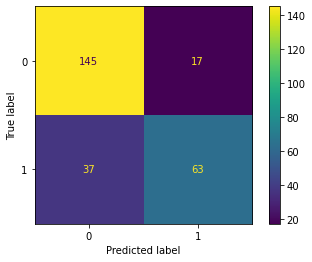

In [15]:
# Visualize that a bit nicer, using sklearn's function to plot CMs
plot_confusion_matrix(model, X_test_pr, y_test);

### Evaluate:

What is a false positive in this context?

- predict someone survive when they didn't


What is a false negative in this context?

- predict someone didn't survive but they did


Which is worse?

- false positive is worse


## Explore Our Metrics

In [16]:
# Define our true positives, true negatives, false positives, and false negatives
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]
tp = cm[1, 1]

### Accuracy
$\frac{TP + TN}{TP + TN + FP + FN}$

In words: How often did my model correctly identify whether or not someone survived? 

In [17]:
# Code it here
(tp+tn)/(tp+tn+fp+fn)

0.7938931297709924

Note: this is the default metric for most classification models, and thus is the score we get when we use `.score`

In [18]:
model.score(X_test_pr, y_test)

0.7938931297709924

### Recall

AKA **Sensitivity**

$\frac{TP}{TP + FN}$

In words: How many of those who actually survived did my model identify? 

In [19]:
# Code it here
tp/(tp+fn)

0.63

### Precision

$\frac{TP}{TP + FP}$

In words: How often was my model's prediction of 'survived' correct?

In [20]:
# Code it here
tp/(tp+fp)

0.7875

### F-Scores

An $F$-score is a combination of precision and recall, which can be useful when both are important for a business problem. 

Most common is the **$F_1$ Score**, which is an equal balance of the two using a [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean).

$$F_1 = 2 \frac{Pr \cdot Rc}{Pr + Rc} = \frac{2TP}{2TP + FP + FN}$$

In [26]:
# Code it here
(2*tp)/(2*tp + fp + fn)

0.7

We can generalize this score to the **$F_\beta$ Score** where increasing $\beta$ puts more importance on _recall_:

$$F_\beta =  \frac{(1+\beta^2) \cdot Precision \cdot Recall}{\beta^2 \cdot Precision + Recall}$$

## `classification_report()`

You can get all of these metrics using the `classification_report()` function. 

- The top rows (here, for 0 and 1) show statistics for if you treated each label as the "positive" class
    - The scores we calculated above all match what is in the `1` row - that's our positive class
- **Support** shows the sample size in each class
- The averages in the bottom two rows are across the rows in the class table above (useful when there are more than two classes)

In [22]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84       162
           1       0.79      0.63      0.70       100

    accuracy                           0.79       262
   macro avg       0.79      0.76      0.77       262
weighted avg       0.79      0.79      0.79       262



Luckily SKLearn will of course calculate these scores for us. You can see all of their classification metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

# Exercise: Breast Cancer Prediction

Let's evaulate a model using Scikit-Learn's breast cancer dataset. [Data description available here](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

This dataset has columns describing tumor details, and is predicting whether or not a tumor is benign. In our target column:
- 0: Malignant
- 1: Benign

In [29]:
# Load the data
preds, target = load_breast_cancer(return_X_y=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    preds, target, random_state=42)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Run the model
bc_model = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
bc_model.fit(X_train_sc, y_train)

LogisticRegression(max_iter=10000, random_state=42)

## Task

**Step 1:** Calculate the following for this model:

- Confusion Matrix
- Accuracy
- Precision
- Recall
- F1 Score


In [37]:
# Your code here - confusion matrix
conf = confusion_matrix(y_test, bc_model.predict(X_test_sc))
conf

array([[53,  1],
       [ 2, 87]], dtype=int64)

In [43]:
test_preds = bc_model.predict(X_test_sc)

In [38]:
tn = conf[0, 0]
fp = conf[0, 1]
fn = conf[1, 0]
tp = conf[1, 1]

In [39]:
# Accuracy
(tp+tn)/(tp+tn+fp+fn)

0.9790209790209791

In [44]:
accuracy_score(y_test, test_preds)

0.9790209790209791

In [40]:
# Precision
tp/(tp+fp)

0.9886363636363636

In [45]:
precision_score(y_test, test_preds)

0.9886363636363636

In [41]:
# Recall
tp/(tp+fn)

0.9775280898876404

In [46]:
recall_score(y_test, test_preds)

0.9775280898876404

In [42]:
# F1 Score
(2*tp)/(2*tp + fp + fn)

0.9830508474576272

In [47]:
f1_score(y_test, test_preds)

0.983050847457627

**Step 2:** Describe your business context:

- What is a false positive in this context?

    - predicting benign but actually malignant
    
- What is a false negative in this context?

    - predicting malignant (0) but actually benign (1)
    
- Which is worse?

    - false positive - told it's fine, don't get necessay treatment fast
    
- Based on the above questions, which metric would you want to optimize on?

    - optimizing precesion would help you minimize false positives
